# Data cleaning and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [2]:
# Data loading
BookData = pd.read_csv("ForecastDataBookingsOriginal.csv")

In [3]:
# Split dataset

# Splitting training+Validationset and testset (70/30)
X_train_val, X_test, y_train_val, y_test = train_test_split(BookData.drop(columns=['IsCanceled']),  BookData['IsCanceled'],  test_size=0.3,  random_state=42)

# Splitting trainingset and validationset (70: 80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,  y_train_val,  test_size=0.2,  random_state=42)

In [4]:
# Missing values

# Impute missing values with mode for the features Children and Country
# Mode of the trainset
ModeChildren = X_train['Children'].mode()[0]
ModeCountry = X_train['Country'].mode()[0]

# Feature: Children
X_train['Children'] = X_train['Children'].fillna(X_train['Children'].mode()[0])
X_val['Children'] = X_val['Children'].fillna(X_train['Children'].mode()[0])
X_test['Children'] = X_test['Children'].fillna(X_train['Children'].mode()[0])

# Feature: Country
X_train['Country'] = X_train['Country'].fillna(X_train['Country'].mode()[0])
X_val['Country'] = X_val['Country'].fillna(X_train['Country'].mode()[0])
X_test['Country'] = X_test['Country'].fillna(X_train['Country'].mode()[0])


# Drop features because many NULL values, and both have over 300 classes. Computational expensive
#Feature: Agent and Company
X_train = X_train.drop(['Agent', 'Company'], axis=1)
X_val = X_val.drop(['Agent', 'Company'], axis=1)
X_test = X_test.drop(['Agent', 'Company'], axis=1)


In [5]:
# One-hot-encoding for categorical features

# Transform feature IsRepeatedGuest to a category
X_train['IsRepeatedGuest'] = X_train['IsRepeatedGuest'].astype('category')
X_val['IsRepeatedGuest'] = X_val['IsRepeatedGuest'].astype('category')
X_test['IsRepeatedGuest'] = X_test['IsRepeatedGuest'].astype('category')

# Top 25 + Other for feature Country (Top 25 from trainset)
TopN = 25
TopCountries = X_train['Country'].value_counts().nlargest(TopN).index
X_train['Country'] = X_train['Country'].apply(lambda x: x if x in TopCountries else 'Other')
X_val['Country'] = X_val['Country'].apply(lambda x: x if x in TopCountries else 'Other')
X_test['Country'] = X_test['Country'].apply(lambda x: x if x in TopCountries else 'Other')

# All categorical features
CategoricalFeatures = ['Country',
                       'Hotel',
                       'Meal',
                       'MarketSegment',
                       'DistributionChannel',
                       'ReservedRoomType',
                       'AssignedRoomType',
                       'DepositType',
                       'CustomerType',
                       'IsRepeatedGuest']

# One-hot-encoding CategoricalFeatures
X_train = pd.get_dummies(X_train, columns=CategoricalFeatures, drop_first=False)
X_val = pd.get_dummies(X_val, columns=CategoricalFeatures, drop_first=False)
X_test = pd.get_dummies(X_test, columns=CategoricalFeatures, drop_first=False)

# Consistency between train, validation and test sets
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)



In [6]:
# Processing date features

# ArrivalDateMonth from Object to Integer
MonthChange = {
                'January': 1,
                'February': 2,
                'March': 3,
                'April': 4,
                'May': 5,
                'June': 6,
                'July': 7,
                'August': 8,
                'September': 9,
                'October': 10,
                'November': 11,
                'December': 12
            }

X_train['ArrivalDateMonth'] = X_train['ArrivalDateMonth'].map(MonthChange)
X_val['ArrivalDateMonth'] = X_val['ArrivalDateMonth'].map(MonthChange)
X_test['ArrivalDateMonth'] = X_test['ArrivalDateMonth'].map(MonthChange)

# Sinus- and cosinustransformation (Arrival month)
X_train['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_train['ArrivalDateMonth'] / 12)
X_train['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_train['ArrivalDateMonth'] / 12)

X_val['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_val['ArrivalDateMonth'] / 12)
X_val['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_val['ArrivalDateMonth'] / 12)

X_test['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_test['ArrivalDateMonth'] / 12)
X_test['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_test['ArrivalDateMonth'] / 12)

# Sinus- and cosinustransformation (Arrival week). Dataset has 53 weeks in a year.
X_train['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_train['ArrivalDateWeekNumber'] / 53)
X_train['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_train['ArrivalDateWeekNumber'] / 53)

X_val['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_val['ArrivalDateWeekNumber'] / 53)
X_val['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_val['ArrivalDateWeekNumber'] / 53)

X_test['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_test['ArrivalDateWeekNumber'] / 53)
X_test['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_test['ArrivalDateWeekNumber'] / 53)

# Sinus- and cosinustransformation (Arrival day of month)

# Function: Check if the year is a leap year
def IsLeapYear(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

# Function: Assign number of days to the months, including the leap year difference for February
def NumberOfDaysInMonth(month, year):
    if month == 2:
        return 29 if IsLeapYear(year) else 28
    return 31 if month in [1, 3, 5, 7, 8, 10, 12] else 30

X_train['ArrivalDateDay_Sin'] = X_train.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_train['ArrivalDateDay_Cos'] = X_train.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

X_val['ArrivalDateDay_Sin'] = X_val.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_val['ArrivalDateDay_Cos'] = X_val.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

X_test['ArrivalDateDay_Sin'] = X_test.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_test['ArrivalDateDay_Cos'] = X_test.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

In [7]:
# Drop features that are correlated to other features in the dataset

features_to_drop = ['ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'ReservationStatusDate', 'ReservationStatus']

X_train = X_train.drop(features_to_drop, axis=1)
X_val = X_val.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)

# Comparison XGBoost (Binary Classification)

In [8]:
# Import libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch


In [9]:
#Label encoding for target value

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


# One-hot encoding for target value not needed


In [10]:
# Smote for class imbalances

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_encoded)

print("Class distribution before SMOTE:", Counter(y_train_encoded))
print("Class distribution after SMOTE:", Counter(y_train_smote))

Class distribution before SMOTE: Counter({0: 42189, 1: 24669})
Class distribution after SMOTE: Counter({0: 42189, 1: 42189})


In [11]:
# Feature standardisation
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Focal Loss for binary classification
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

def f1_macro(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, 'float32')
    y_true = tf.cast(y_true, 'float32')

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    f1 = 2 * tp / (2 * tp + fp + fn + K.epsilon())
    return f1

# Model creation for binary classification
def create_model(n_hidden=2, n_neurons=64, activation='relu', dropout_rate=0.5, learning_rate=0.001, l2_lambda=0.01):
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=X_train_smote.shape[1], activation=activation,
                    kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation, kernel_regularizer=l2(l2_lambda)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Only 1 output neuron for binary classification
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=focal_loss(), metrics=[f1_macro])
    return model


In [13]:
# Hyperparameter tuning

def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=2, max_value=6, step=1)
    n_neurons = hp.Int('n_neurons', min_value=16, max_value=256, step=16)
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.0001])
    return create_model(n_hidden, n_neurons, activation, dropout_rate, learning_rate)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='ann_tuning',
    project_name='hotel_booking_cancellation'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train_smote, y_train_smote, epochs=20, validation_data=(X_val_scaled, y_val_encoded), verbose=2)


Trial 10 Complete [00h 04m 56s]
val_loss: 3.3343390271056705e-08

Best val_loss So Far: 1.1424284435124221e-10
Total elapsed time: 01h 13m 52s


In [14]:
# Best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Hidden Layers: {best_hps.get('n_hidden')}
- Neurons per Layer: {best_hps.get('n_neurons')}
- Activation: {best_hps.get('activation')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")



Best hyperparameters:
- Hidden Layers: 5
- Neurons per Layer: 96
- Activation: sigmoid
- Dropout Rate: 0.4
- Learning Rate: 0.0001



In [15]:
# Final model training
final_model = tuner.hypermodel.build(best_hps)
final_model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val_scaled, y_val_encoded),
    epochs=25,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)





Epoch 1/25
2637/2637 - 20s - 8ms/step - f1_macro: 0.6110 - loss: 1.8417 - val_f1_macro: 0.5363 - val_loss: 0.1721
Epoch 2/25
2637/2637 - 20s - 8ms/step - f1_macro: 0.6617 - loss: 0.0349 - val_f1_macro: 0.5363 - val_loss: 5.7581e-04
Epoch 3/25
2637/2637 - 21s - 8ms/step - f1_macro: 0.6621 - loss: 2.0451e-04 - val_f1_macro: 0.5363 - val_loss: 7.4488e-05
Epoch 4/25
2637/2637 - 19s - 7ms/step - f1_macro: 0.6617 - loss: 3.5955e-05 - val_f1_macro: 0.5363 - val_loss: 1.3286e-05
Epoch 5/25
2637/2637 - 15s - 6ms/step - f1_macro: 0.6617 - loss: 7.4555e-06 - val_f1_macro: 0.5363 - val_loss: 2.5629e-06
Epoch 6/25
2637/2637 - 14s - 5ms/step - f1_macro: 0.6620 - loss: 1.6913e-06 - val_f1_macro: 0.5363 - val_loss: 5.1564e-07
Epoch 7/25
2637/2637 - 21s - 8ms/step - f1_macro: 0.6619 - loss: 4.0608e-07 - val_f1_macro: 0.5363 - val_loss: 1.0772e-07
Epoch 8/25
2637/2637 - 14s - 5ms/step - f1_macro: 0.6620 - loss: 1.0243e-07 - val_f1_macro: 0.5363 - val_loss: 2.4387e-08
Epoch 9/25
2637/2637 - 20s - 8ms/ste

In [29]:
# Predicting
y_train_pred = final_model.predict(X_train_smote)
y_val_pred = final_model.predict(X_val_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# For sigmoid label to 0 or 1 (prediction)
y_train_pred_classes = (y_train_pred > 0.5).astype(int)
y_val_pred_classes = (y_val_pred > 0.5).astype(int)
y_test_pred_classes = (y_test_pred > 0.5).astype(int)

# True classes to 0 of 1
y_train_true_classes = y_train_smote
y_val_true_classes = y_val_encoded
y_test_true_classes = y_test_encoded



2637/2637 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Train Set Results
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     42189
           1       0.50      1.00      0.67     42189

    accuracy                           0.50     84378
   macro avg       0.25      0.50      0.33     84378
weighted avg       0.25      0.50      0.33     84378



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


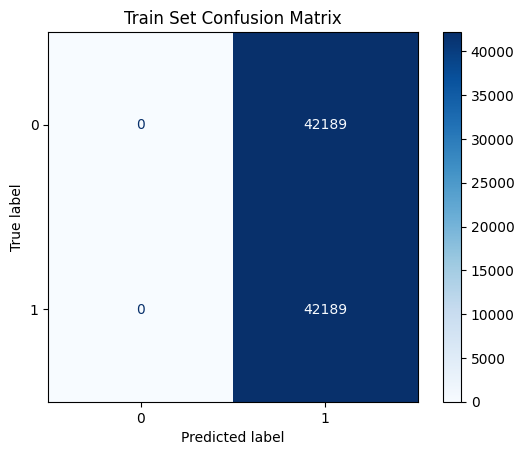

Validation Set Results
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10499
           1       0.37      1.00      0.54      6216

    accuracy                           0.37     16715
   macro avg       0.19      0.50      0.27     16715
weighted avg       0.14      0.37      0.20     16715



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


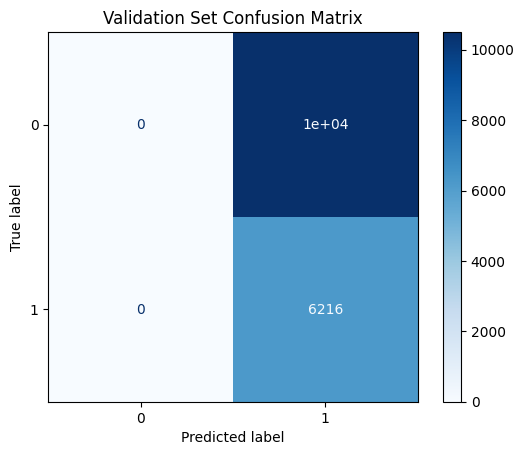

Test Set Results
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     22478
           1       0.00      0.00      0.00     13339

    accuracy                           0.63     35817
   macro avg       0.31      0.50      0.39     35817
weighted avg       0.39      0.63      0.48     35817



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


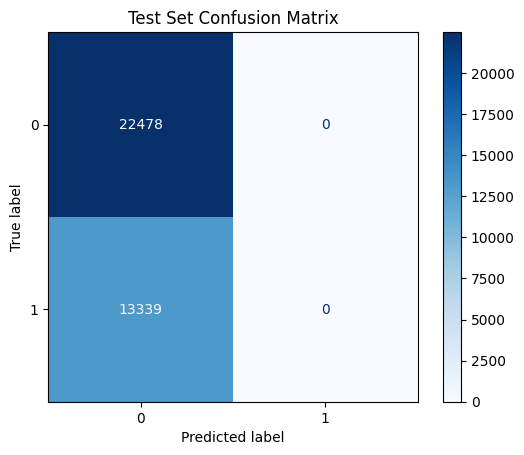

In [17]:
# Evaluation with classification report and confusion matrix

# Train Set Results
print("Train Set Results")
print(classification_report(y_train_true_classes, y_train_pred_classes))
train_cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix")
plt.show()

# Validation Set Results
print("Validation Set Results")
print(classification_report(y_val_true_classes, y_val_pred_classes))
val_cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix")
plt.show()

# Test Set Results
print("Test Set Results")
print(classification_report(y_test_true_classes, y_test_pred_classes))
test_cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix")
plt.show()

## Feature Importance Analysis

In [46]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = np.array([0, 1])

    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def predict_proba(self, X):
        return self.model.predict(X)


In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

wrapped_model = KerasModelWrapper(final_model)

# Permutation Importance
perm_importance = permutation_importance(
    wrapped_model,
    X_val_scaled,
    y_val_encoded,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

# Sorting
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]

# Visualisation
plt.figure(figsize=(10, 8))
plt.barh(
    [X_train.columns[i] for i in sorted_idx],
    perm_importance.importances_mean[sorted_idx],
    color='skyblue'
)
plt.xlabel("Gemiddelde Belangscore (Afname in Accuracy)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.show()

523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━

                      Feature  Mean Importance  Importance StdDev
0          ArrivalDateDay_Cos              0.0                0.0
1          ArrivalDateDay_Sin              0.0                0.0
70  ArrivalDateWeekNumber_Cos              0.0                0.0
69  ArrivalDateWeekNumber_Sin              0.0                0.0
68       ArrivalDateMonth_Cos              0.0                0.0
..                        ...              ...                ...
29          StaysInWeekNights              0.0                0.0
28       StaysInWeekendNights              0.0                0.0
27            ArrivalDateYear              0.0                0.0
26          DaysInWaitingList              0.0                0.0
95                   LeadTime              0.0                0.0

[96 rows x 3 columns]
Top Features:
                         Feature  Mean Importance  Importance StdDev
0             ArrivalDateDay_Cos              0.0                0.0
1             ArrivalDateDay_Sin 

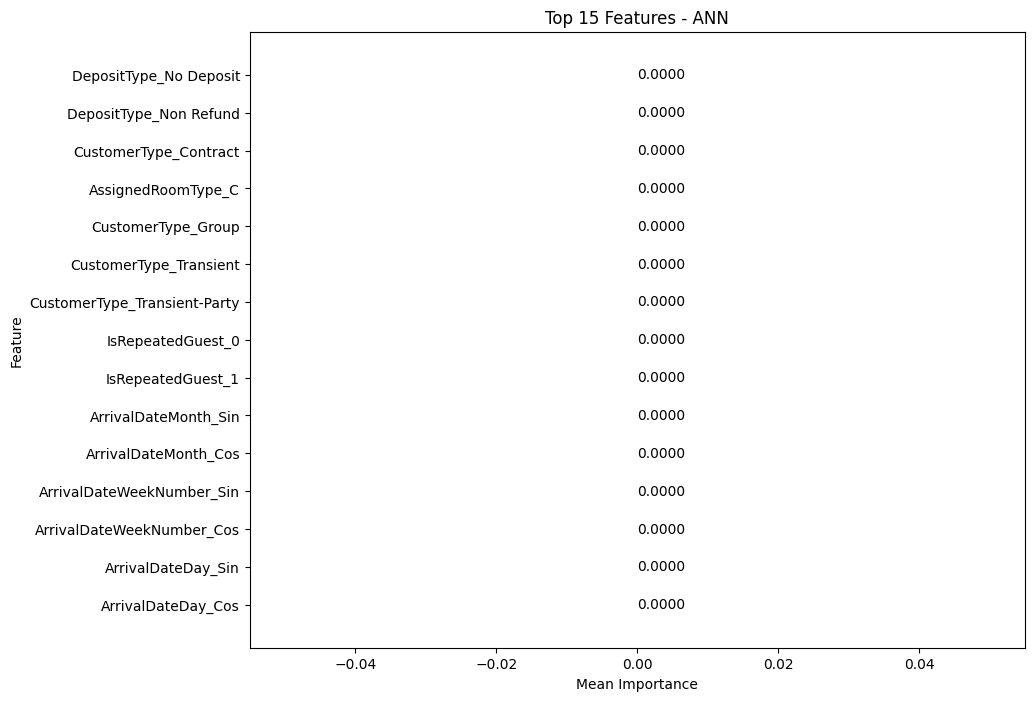

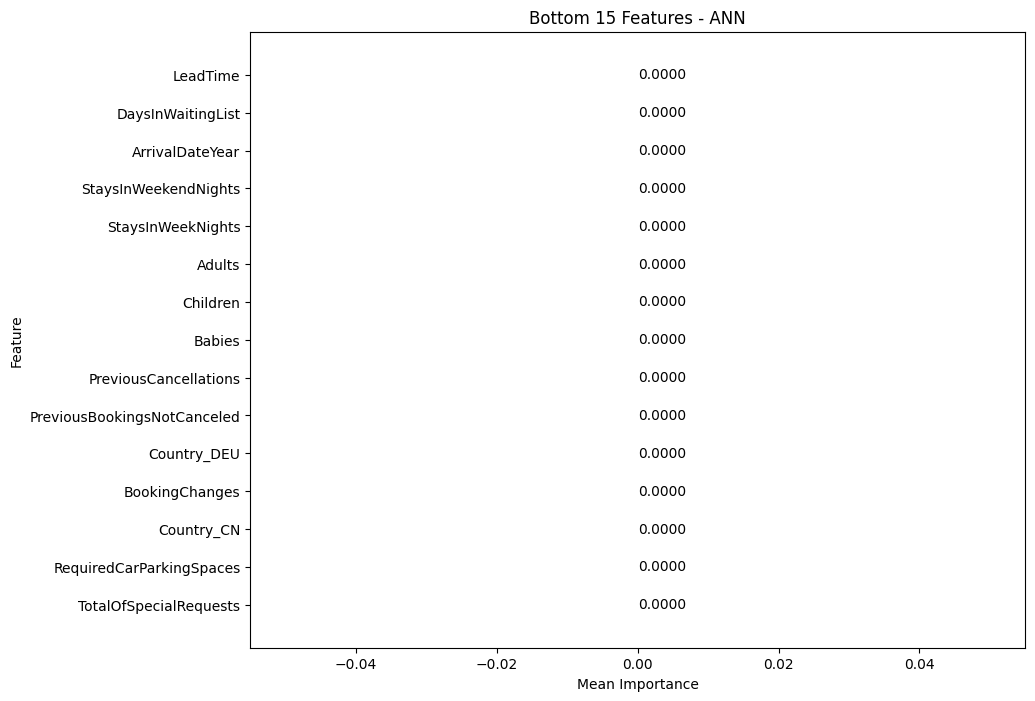

In [52]:
# Important features
importance_df = pd.DataFrame({
    'Feature': [feature_names[i] for i in sorted_idx],
    'Mean Importance': perm_importance.importances_mean[sorted_idx],
    'Importance StdDev': perm_importance.importances_std[sorted_idx]
}).sort_values(by='Mean Importance', ascending=False)

print(importance_df)

# Top and bottom features
top_n = 15
top_features = importance_df.head(top_n)
bottom_features = importance_df.tail(top_n)

top_features.reset_index(drop=True, inplace=True)
bottom_features.reset_index(drop=True, inplace=True)

print("Top Features:")
print(top_features)

print("\nBottom Features:")
print(bottom_features)

# Visualisation top features
top_features_sorted = top_features.sort_values(by='Mean Importance', ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_features_sorted['Feature'], top_features_sorted['Mean Importance'], color='green')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.title("Top 15 Features - ANN")

for bar, value in zip(bars, top_features_sorted['Mean Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.4f}', va='center')

plt.show()

# Visualisation bottom features
bottom_features_sorted = bottom_features.sort_values(by='Mean Importance', ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(bottom_features_sorted['Feature'], bottom_features_sorted['Mean Importance'], color='red')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.title("Bottom 15 Features - ANN")

for bar, value in zip(bars, bottom_features_sorted['Mean Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.4f}', va='center')

plt.show()
